In [5]:
from fastai.tabular.all import *
from warnings import simplefilter
set_seed(42)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [6]:
df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')
mixed_type = [98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730]
for column in mixed_type:
    df[df.columns[column]] = pd.to_numeric(df[df.columns[column]], errors='coerce')
df.replace(to_replace='.', value=np.NaN, inplace=True)
df.replace(regex='^[.;]+$', value=np.NaN, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'association'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Affects'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'other'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_drug_response,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_other,_risk_factor', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_risk_factor', value='Likely_benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
df.select_dtypes(include=[np.number]).replace(to_replace=np.NaN, value=0, inplace=True)
df.select_dtypes(include=[object]).replace(to_replace=np.NaN, value=df.mode().iloc[0], inplace=True)

/tmp/ipykernel_17630/3139588305.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')


In [7]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [9]:
dls = to.dataloaders(bs=1024)

In [10]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=10))

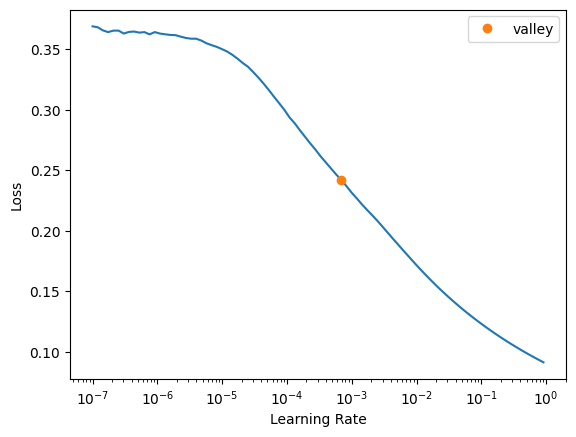

In [11]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.239791,0.173401,0.119403,00:00
1,0.165754,0.167373,0.125373,00:00
2,0.131556,0.161510,0.204478,00:00
3,0.108960,0.153420,0.280597,00:00
4,0.091553,0.142004,0.460448,00:00
5,0.077426,0.126618,0.625373,00:00
6,0.065328,0.109731,0.706716,00:00
7,0.055251,0.099636,0.720149,00:00
8,0.046954,0.097390,0.735821,00:00
9,0.040163,0.098385,0.747015,00:00


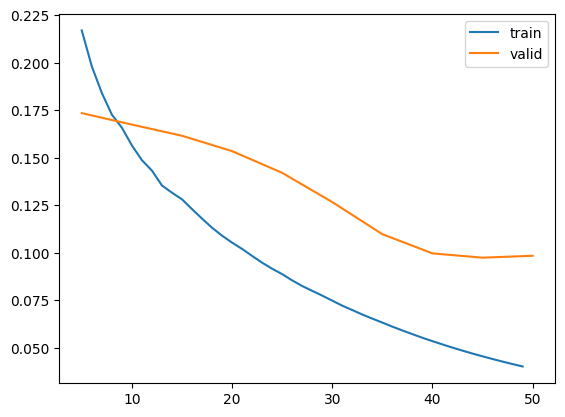

In [12]:
learn.fit(10, lr, wd=0.1)
learn.recorder.plot_loss()

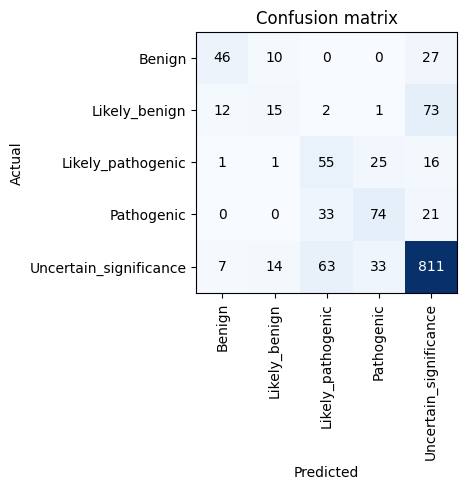

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [21]:
test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
mixed_type = [98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730]
for column in mixed_type:
    test_df[test_df.columns[column]] = pd.to_numeric(test_df[test_df.columns[column]], errors='coerce')
test_df.replace(to_replace='.', value=np.nan, inplace=True)
test_df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.dropna(axis='columns', thresh=int(len(test_df.index)*0.8), inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
test_df.fillna(test_df.mode().iloc[0], inplace=True)
test_df['Gene_other_names'] = np.nan
test_df['Trait_association(GWAS)'] = np.nan
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

/tmp/ipykernel_17630/1959560360.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


(#2) [5835575.5,0.11012262850999832]

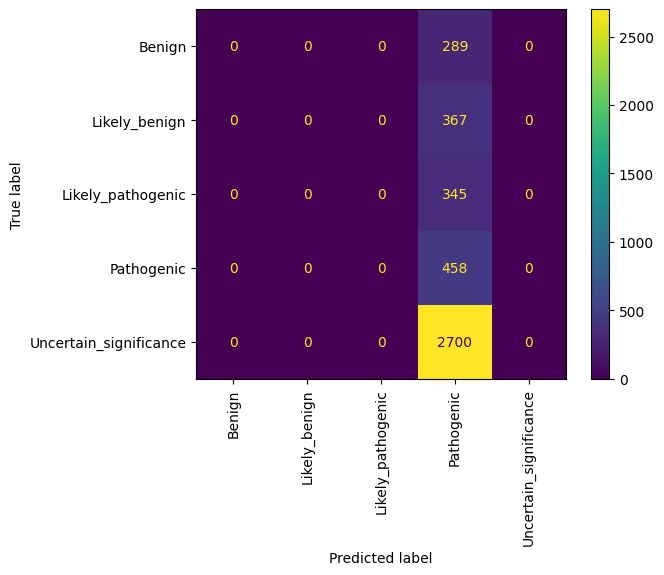

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds, targets = learn.get_preds(dl=test_dl)
pred_classes = np.argmax(preds, axis=1)

# Flattening delle etichette di classe
true_classes = targets.squeeze().numpy()

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')